In [1]:
import pickle


In [6]:
with open('data_quicksafe_old2.pkl', 'rb') as f:
    Xtrain, ytrain, Xval, yval = pickle.load(f)

In [7]:
 ytrain.sum()

np.int64(351)

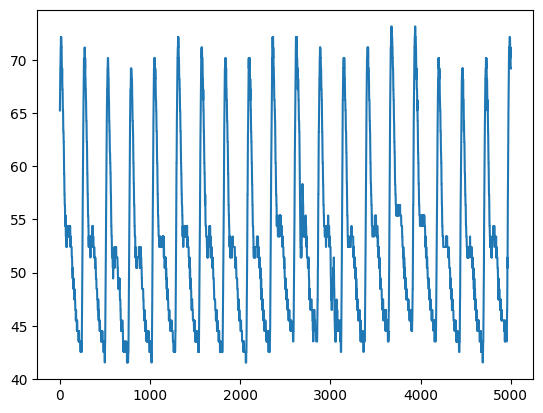

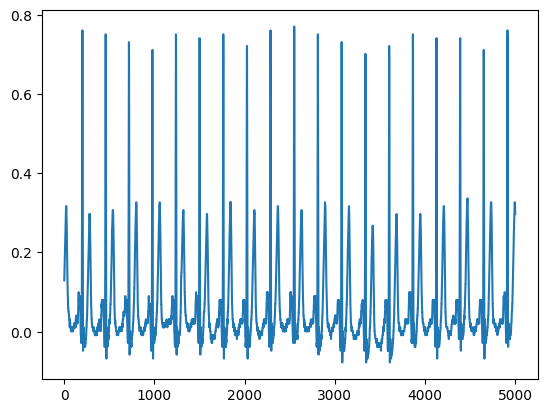

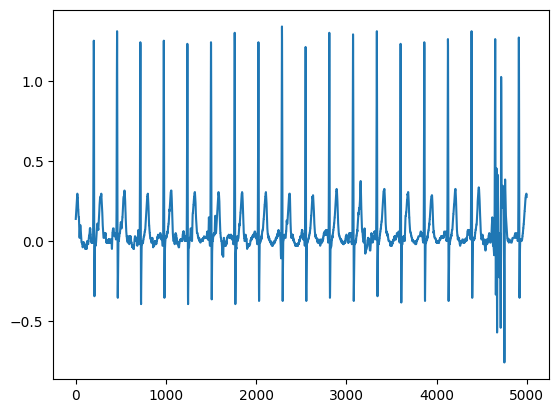

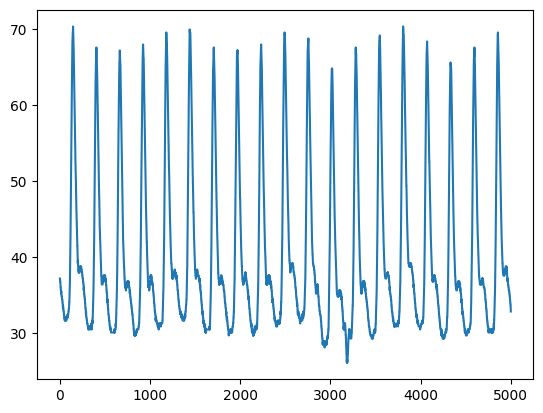

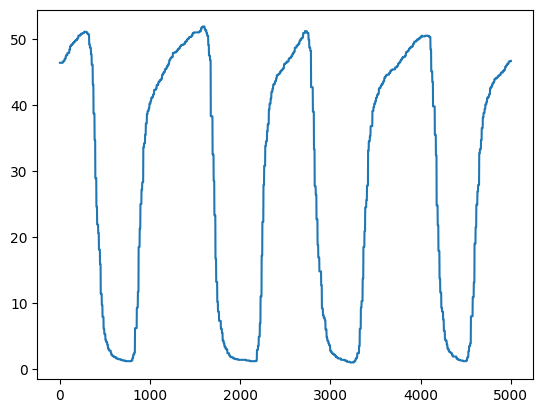

In [8]:
# Plot some examples
import matplotlib.pyplot as plt
example = Xtrain[0]
for i in range(example.shape[1]):
    plt.plot(example[:, i])
    plt.show()


In [9]:
import numpy as np
from scipy.stats import kurtosis,skew
import pywt
import antropy as ant  # for sample entropy

coeffs = pywt.wavedec(example[:, 1], 'bior3.3', level=5)
features = []
for subband in coeffs:
    # Sample entropy
    sampen = ant.sample_entropy(subband)
    # Wavelet entropy (Shannon entropy of normalized coefficient energy)
    e = subband**2
    p = e / np.sum(e)
    wavelet_entropy = -np.sum(p * np.log2(p + 1e-12))
    features.extend([sampen, wavelet_entropy])
# Wavelet Decomposition

features

[0.944683806375373,
 np.float64(5.941313805655847),
 1.0758442298618778,
 np.float64(5.211600873102398),
 0.33891200311250935,
 np.float64(4.539260303525897),
 0.1861170347340909,
 np.float64(5.037624901891191),
 1.219973764342416,
 np.float64(6.819513151520951),
 1.4142603160357763,
 np.float64(9.434877910265502)]

(5000,)
[ 281 1593 2725 4067]


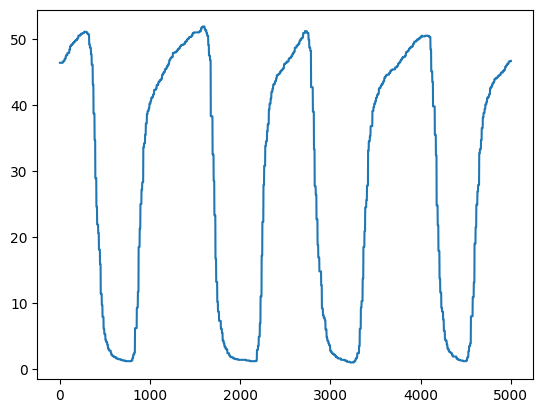

In [10]:
import numpy as np
from scipy.signal import find_peaks
from scipy.stats import linregress


fs = 250
signal = example[:, -1]

print(signal.shape)
etco2_list = []
# Detect inspiration minima
peaks, _ = find_peaks(signal, distance=int(0.7*fs))

for i in range(len(peaks)):
    etco2_max = signal[i]
    etco2_list.append(etco2_max)

mean = np.mean(etco2_list)
std = np.std(etco2_list)
print(peaks)
# plt
plt.plot(signal)



In [11]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks

def bandpass_filter(x, fs, lowcut=0.5, highcut=30.0, order=3):
    nyq = 0.5 * fs
    if highcut >= nyq:
        highcut = max(nyq - 0.1, lowcut + 0.1)
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, x)

def detect_systolic_peaks(sig, fs, min_bpm=30, max_bpm=200):
    min_distance = int((60.0 / max_bpm) * fs * 0.9)
    prom = max(0.35 * np.std(sig), 0.05 * (np.max(sig) - np.min(sig)))
    peaks, _ = find_peaks(sig, distance=min_distance, prominence=prom)
    return peaks

def find_pulse_foot(sig, peak_idx, fs, max_back=0.5):
    start = max(0, peak_idx - int(max_back * fs))
    window = sig[start:peak_idx+1]
    if window.size == 0:
        return None
    rel_idx = np.argmin(window)
    return start + rel_idx

def find_dicrotic_notch(sig, peak_idx, fs, max_forward=0.6):
    start = peak_idx + 1
    end = min(len(sig), peak_idx + int(max_forward * fs))
    if end <= start + 2:
        return None
    segment = sig[start:end]
    inv = -segment
    mins, _ = find_peaks(inv, distance=int(0.05*fs), prominence=np.std(inv)*0.3)
    if mins.size > 0:
        return start + mins[0]
    return start + np.argmin(segment)

def extract_abp_features(abp, fs, preprocess=True):
    abp = np.asarray(abp).astype(float)
    sig = bandpass_filter(abp, fs, 0.5, min(30.0, 0.49*fs)) if preprocess else abp.copy()
    sig = sig - np.mean(sig)

    peaks = detect_systolic_peaks(sig, fs)
    beats = []

    for i, pk in enumerate(peaks):
        foot = find_pulse_foot(sig, pk, fs)
        if foot is None:
            continue
        if i + 1 < len(peaks):
            next_pk = peaks[i+1]
            next_foot = find_pulse_foot(sig, next_pk, fs) or int((pk + next_pk) / 2)
        else:
            next_foot = min(len(sig)-1, pk + int(1.2 * fs))

        ibi = (next_foot - foot) / fs
        if not (0.25 <= ibi <= 2.5):
            continue

        beat_seg = abp[foot:next_foot+1]
        if beat_seg.size < 5:
            continue

        SBP = abp[pk]
        DBP = abp[foot]
        area = np.trapezoid(beat_seg, dx=1.0/fs)
        MAP = area / ibi
        PP = SBP - DBP

        dpdt = np.gradient(beat_seg, 1.0/fs)
        peak_rel = pk - foot
        max_dPdt = np.max(dpdt[:peak_rel+1]) if 0 <= peak_rel < dpdt.size else np.max(dpdt)

        notch_idx = find_dicrotic_notch(abp, pk, fs)
        if notch_idx and foot < notch_idx <= next_foot:
            systolic_area = np.trapezoid(abp[foot:notch_idx+1], dx=1.0/fs)
        else:
            cut = foot + int(0.6 * (next_foot - foot))
            systolic_area = np.trapezoid(abp[foot:cut+1], dx=1.0/fs)

        hr = 60.0 / ibi

        beats.append({
            "beat_index": i,
            "SBP": float(SBP),
            "DBP": float(DBP),
            "MAP": float(MAP),
            "PP": float(PP),
            "IBI": float(ibi),
            "HR": float(hr),
            "max_dPdt": float(max_dPdt),
            "systolic_area": float(systolic_area),
        })

    return pd.DataFrame(beats)


In [12]:
example_signal = example[:, 0]
fs = 250
df_features = extract_abp_features(example_signal, fs)

# Get mean of features, ignore first two beats
df_features = df_features.iloc[2:].mean().to_frame().T
# Remove Beat index
df_features = df_features.drop(columns=['beat_index'])
# as array
df_features = df_features.values.flatten()

In [13]:
df_features

array([ 69.03483815,  42.70265049,  52.68149271,  26.33218765,
         1.03511111,  58.15662263, 432.01618724,  28.22942283])

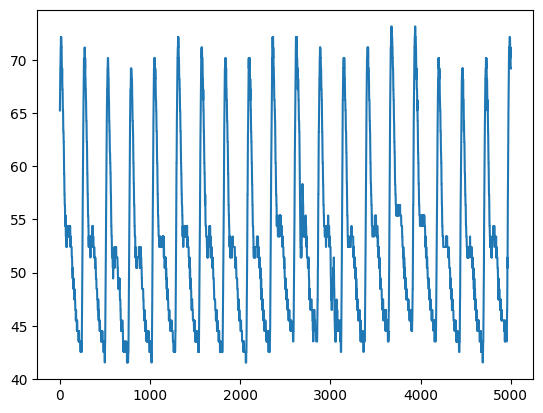

In [14]:
from matplotlib import pyplot as plt
plt.plot(example_signal)

In [15]:
import neurokit2 as nk
results = {}

ecg = Xtrain[6373, :, 1]
abp = Xtrain[6373,:, 0]
ppg = Xtrain[6373,:, 3]

# --- Step 1: R-peak detection in ECG ---
ecg_processed, ecg_info = nk.ecg_process(ecg, sampling_rate=fs)
r_peaks = ecg_info["ECG_R_Peaks"]

# --- Step 2: Find ABP and PPG "foot" (pulse onset) ---
# Simplest method: find minima before systolic upstroke
# More robust: use derivative-based method
abp_diff = np.diff(abp)
ppg_diff = np.diff(ppg)

abp_foot, _ = find_peaks(abp, distance=int(0.3*fs), height=60)
ppg_foot, _ = find_peaks(ppg, distance=int(0.3*fs), height=50)

# --- Step 3: Match beats ---
ptt_values = []
pat_values = []
for r in r_peaks:
    # Find closest ABP foot after R-peak
    abp_candidates = abp_foot[abp_foot > r]
    ppg_candidates = ppg_foot[ppg_foot > r]

    if len(abp_candidates) > 0:
        ptt = (abp_candidates[0] - r) / fs
        ptt_values.append(ptt)
    if len(ppg_candidates) > 0:
        pat = (ppg_candidates[0] - r) / fs
        pat_values.append(pat)

results["PTT"] = np.array(ptt_values)
results["PAT"] = np.array(pat_values)
results


{'PTT': array([0.304, 0.284, 0.284, 0.284, 0.284, 0.284, 0.28 , 0.276, 0.28 ,
        0.272, 0.284, 0.276, 0.552, 0.44 , 0.288, 0.136, 0.276, 0.708,
        0.276, 0.272, 0.264, 0.268, 0.264, 0.268, 0.02 , 0.264, 0.272]),
 'PAT': array([0.132, 0.088, 0.112, 0.064, 0.116, 0.064, 0.112, 0.064, 0.096,
        0.064, 0.116, 0.204, 0.6  , 0.296, 0.12 , 0.676, 0.096, 0.5  ,
        0.068, 0.108, 0.048, 0.104, 0.052, 0.096, 0.572, 0.048, 0.108])}

In [16]:
def detect_systolic_diastolic_peaks(signal):
    peaks, _ = find_peaks(signal, distance=int(0.3*fs), height=signal.mean()+5)
    peaks_inverse, _ = find_peaks(-signal, distance=int(0.3*fs), height=-signal.mean()+5,)
    peaks_all = peaks_inverse

    # Filter Diastolic peaks by removing all but the first one after the peak foot
    for i in range(len(peaks)-1):
        mask = (peaks_all > peaks[i]) & (peaks_all < peaks[i+1])
        if np.sum(mask) > 1:
            to_remove = peaks_all[mask][1:]
            peaks_all = peaks_all[~np.isin(peaks_all, to_remove)]

    abp_diastolic_new = []
    for i in range(len(peaks)-1):
        mask = (peaks_inverse > peaks[i]) & (peaks_inverse < peaks[i+1])
        if np.sum(mask) > 0:
            to_keep = peaks_inverse[mask]
            closest = to_keep[np.argmin(peaks[i+1] - to_keep)]
            abp_diastolic_new.append(closest)

    return peaks, peaks_inverse, abp_diastolic_new


In [116]:
peaks, _ = find_peaks(abp, distance=int(0.3*fs), height=abp.mean()+5)
ppg_peaks, _ = find_peaks(ppg, distance=int(0.3*fs), height=ppg.mean()+3)

# Find distolic peaks
peaks_inverse, _ = find_peaks(-abp, distance=int(0.3*fs), height=-abp.mean()+5,)
ppg_diastolic, _ = find_peaks(-ppg, distance=int(0.3*fs), height=-ppg.mean()+3)

# Filter Diastolic peaks by removing all but the points but the one that is closest right before the next peak
abp_diastolic_new = []
for i in range(len(peaks)-1):
    mask = (peaks_inverse > peaks[i]) & (peaks_inverse < peaks[i+1])
    if np.sum(mask) > 0:
        to_keep = peaks_inverse[mask]
        closest = to_keep[np.argmin(peaks[i+1] - to_keep)]
        abp_diastolic_new.append(closest)


In [167]:
ytrain[8140]

np.True_

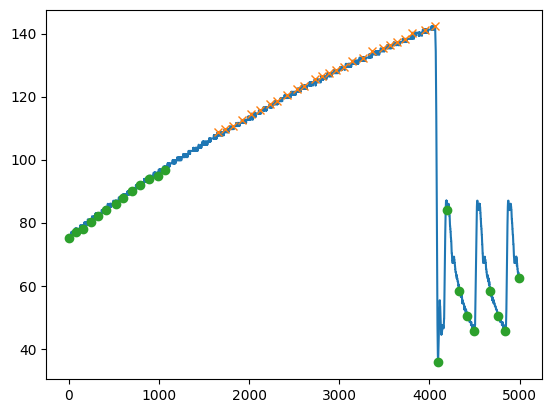

In [166]:
#plot abp with foot points
abp = Xtrain[6357,:,0]
peaks, peaks_inverse, peaks_second = detect_systolic_diastolic_peaks(abp)
plt.plot(abp)
plt.plot(peaks, abp[peaks], "x")
plt.plot(peaks_inverse, abp[peaks_inverse], "o")
plt.plot(peaks_second, abp[peaks_second], "s")
plt.show()


False


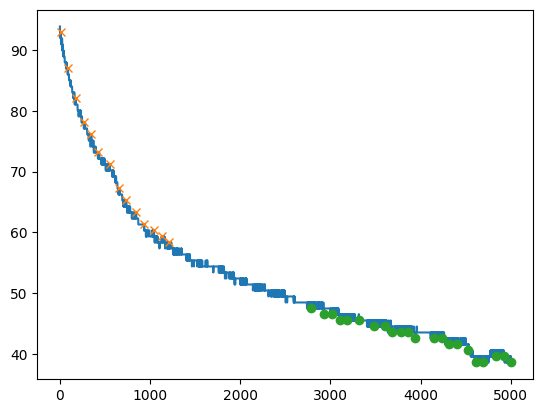

In [169]:
abp = Xval[916,:,0]
print(yval[916])
peaks, peaks_inverse, peaks_second = detect_systolic_diastolic_peaks(abp)
plt.plot(abp)
plt.plot(peaks, abp[peaks], "x")
plt.plot(peaks_inverse, abp[peaks_inverse], "o")
plt.plot(peaks_second, abp[peaks_second], "s")
plt.show()


In [126]:
syst_peaks, dicrotic_peaks, diastolic_peaks = detect_systolic_diastolic_peaks(abp)

pp_values = []
diastolic_peaks = np.array(diastolic_peaks)
for i in range(len(syst_peaks)-1):
    mask = (diastolic_peaks > syst_peaks[i]) & (diastolic_peaks < syst_peaks[i+1])
    if np.sum(mask) > 0:
        diastolic_peak = diastolic_peaks[mask][0]
        pp = abp[syst_peaks[i]] - abp[diastolic_peak]
        pp_values.append(pp)

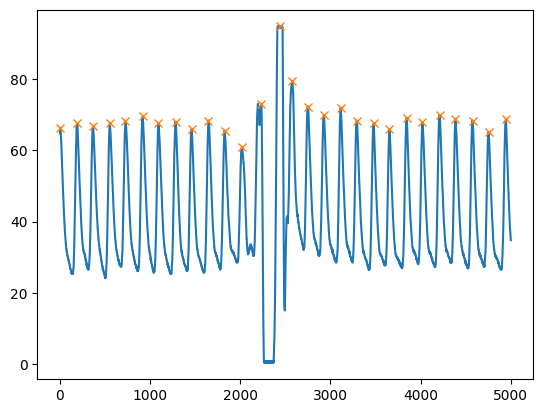

In [89]:
# Plot ppg with foot points
plt.plot(ppg)
plt.plot(ppg_foot, ppg[ppg_foot], "x")
plt.show()

In [54]:
from sklearn.impute import KNNImputer

ecg_bad = example[:, 1]
ecg_bad[4999] = np.nan

ecg_bad[-10:]

array([0.29701099, 0.30688599, 0.30688599, 0.31676099, 0.326635  ,
       0.326635  , 0.31676099, 0.31676099, 0.31676099,        nan])

In [53]:

imputer = KNNImputer(n_neighbors=3, weights="uniform")
imputer.fit_transform(ecg_bad.reshape(-1, 1)).flatten()

array([0.129144  , 0.139018  , 0.139018  , ..., 0.31676099, 0.31676099,
       0.06309728], shape=(5000,))

In [55]:
np.isnan(ecg_bad).sum()

np.int64(1)

In [141]:
ts = np.array([[2], [np.nan], [6], [8], [np.nan], [10]])
np.delete(ts, 1, axis=0)

array([[ 2.],
       [ 6.],
       [ 8.],
       [nan],
       [10.]])

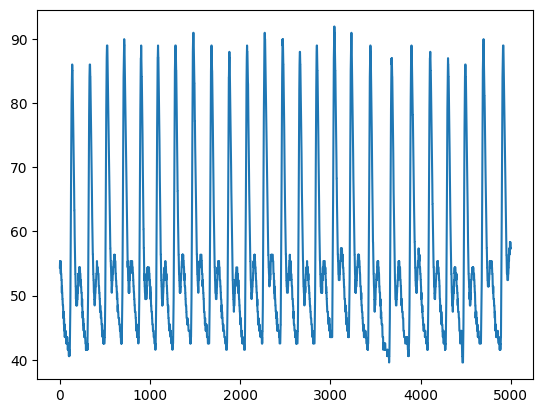

In [144]:
example2 = Xtrain[3426]

# Plot ecg
plt.plot(example2[:, 0])
plt.show()

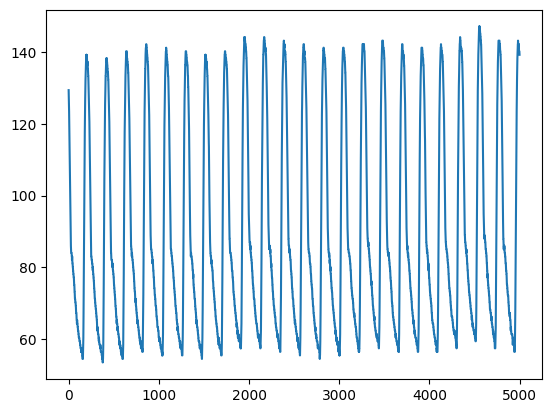

In [35]:
# Plot ecg
plt.plot(Xtrain[6355, :, 0])
#r_peaks = find_peaks(ecg, distance=int(0.6*fs), height=ecg.mean()+0.5*ecg.std())[0]
#plt.plot(r_peaks, example2[r_peaks, 1], "x")

Data loaded from pickle file.


Computing features: 100%|██████████| 1575/1575 [00:00<00:00, 1804.39it/s]


GBM auroc: 0.967, auprc: 0.482
              precision    recall  f1-score   support

       False       0.99      1.00      0.99      1542
        True       0.68      0.39      0.50        33

    accuracy                           0.98      1575
   macro avg       0.84      0.70      0.75      1575
weighted avg       0.98      0.98      0.98      1575

[[1536    6]
 [  20   13]]


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

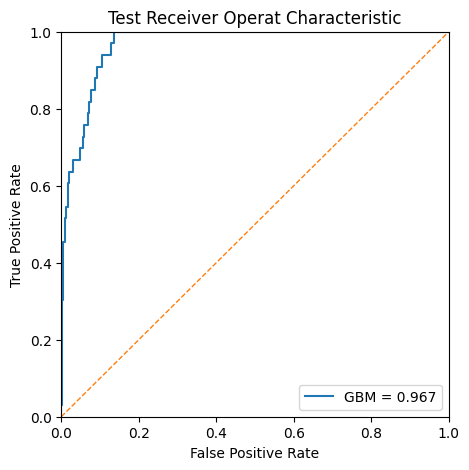

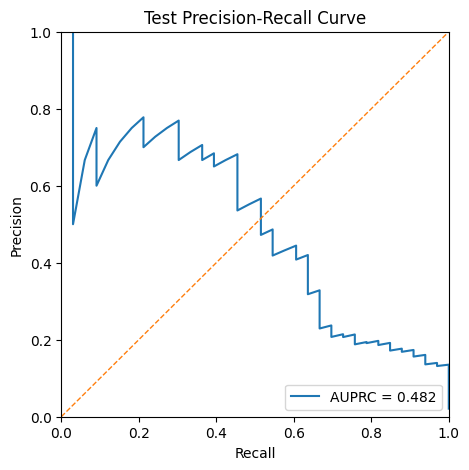

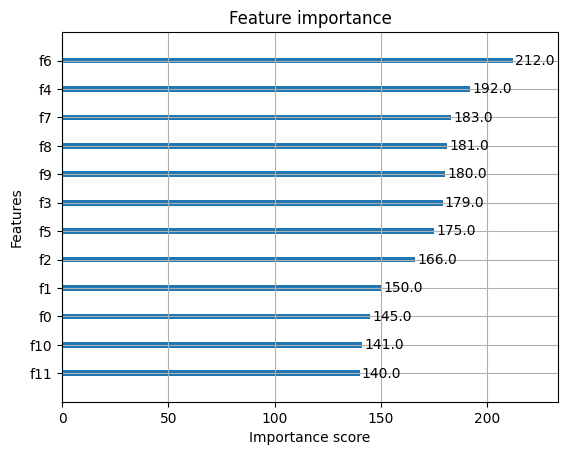

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import plot_importance, XGBClassifier

from dataset import VitalDBReader
from features_comp import prepare_data
from model import fit_model,evaluate_model,save_model

import pickle


pickle_path = 'data_quicksafe.pkl'

try:
    with open(pickle_path, 'rb') as f:
        Xtrain, ytrain, Xval, yval = pickle.load(f)
    print("Data loaded from pickle file.")
except FileNotFoundError:


    Xtrain,ytrain,Xval,yval=VitalDBReader.get_data("cholecystectomy",100)

    with open(pickle_path, 'wb') as f:
        pickle.dump((Xtrain, ytrain, Xval, yval), f)

to_dispose = [1885, 3427, 3546, 5074, 6924, 7103, 7102, 8140]
Xtrain = np.delete(Xtrain, to_dispose, axis=0)
ytrain = np.delete(ytrain, to_dispose, axis=0)

to_dispose_val = [916]
Xval = np.delete(Xval, to_dispose_val, axis=0)
yval = np.delete(yval, to_dispose_val, axis=0)

Xtrain=prepare_data(Xtrain)
Xval=prepare_data(Xval)

xgb = XGBClassifier()
xgb.fit(Xtrain, ytrain)

evaluate_model(xgb,Xval,yval)
plot_importance(xgb)


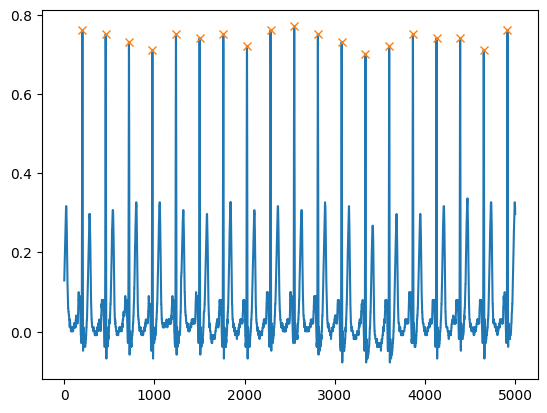

In [29]:
# Plot ppg
plt.plot(example[:, 1])
# Find peaks and plot
ppg_peaks, _ = find_peaks(example[:, 1], distance=int(0.3*fs), height=np.percentile(example[:, 1], 98))

plt.plot(ppg_peaks, example[ppg_peaks, 1], "x")

In [36]:
howmany = ['abp_syst_peaks_min', 'abp_syst_peaks_max', 'abp_syst_peaks_kurtosis', 'abp_syst_peaks_sum', 'abp_syst_peaks_var', 'abp_syst_peaks_var_coeff', 'abp_ditr_peaks_mean', 'abp_ditr_peaks_min', 'abp_ditr_peaks_max', 'abp_ditr_peaks_kurtosis', 'abp_ditr_peaks_median', 'abp_ditr_peaks_var', 'abp_dist_peaks_min', 'abp_dist_peaks_kurtosis', 'abp_dist_peaks_skewness', 'abp_dist_peaks_sum', 'abp_dist_peaks_var', 'pulse_pressure_median', 'pulse_pressure_var', 'pulse_pressure_var_coeff', 'pulse_transit_time_var_coeff', 'syst_dist_time_diff_max', 'syst_dist_time_diff_kurtosis', 'syst_dist_time_diff_sum', 'syst_dist_time_diff_var', 'abp_hr_sum', 'raw_ecgii_mean', 'raw_ecgii_kurtosis', 'raw_ecgii_skewness', 'raw_ecgii_sum', 'raw_ecgii_var_coeff', 'raw_abp_mean', 'raw_abp_max', 'raw_abp_median', 'raw_abp_sum', 'raw_ppg_min', 'raw_ppg_skewness', 'raw_ppg_var', 'raw_ppg_var_coeff', 'raw_ecgv_mean', 'raw_ecgv_median', 'wavelet_entropies_ecgii_0', 'wavelet_entropies_ecgii_2', 'wavelet_entropies_ecgii_5', 'wavelet_entropies_ecgii_6', 'wavelet_entropies_ecgii_7', 'wavelet_entropies_ecgii_8', 'wavelet_entropies_ecgii_10', 'wavelet_entropies_ecgii_filtered_0', 'wavelet_entropies_ecgii_filtered_2', 'wavelet_entropies_ecgii_filtered_3', 'wavelet_entropies_ecgii_filtered_5', 'wavelet_entropies_ecgii_filtered_7', 'wavelet_entropies_ecgii_filtered_8', 'wavelet_entropies_abp_0', 'wavelet_entropies_abp_2', 'wavelet_entropies_abp_3', 'wavelet_entropies_abp_7', 'wavelet_entropies_abp_9', 'wavelet_entropies_abp_11', 'wavelet_entropies_ppg_0', 'wavelet_entropies_ppg_1', 'wavelet_entropies_ppg_4', 'wavelet_entropies_ppg_5', 'wavelet_entropies_ppg_7', 'wavelet_entropies_ppg_10']

print(len(howmany))

66


In [38]:
# New Features:
import scipy.signal as signal
from scipy.fft import fft, fftfreq
fs = 250  # Sampling frequency
def compute_hrv_freq(ecg_signal):
    # R-peak detection (simple, replace with robust detector in practice)
    peaks, _ = signal.find_peaks(ecg_signal, distance=int(0.25*fs))  # ensure integer distance
    if len(peaks) < 2:
        return np.nan, np.nan, np.nan

    rr_intervals = np.diff(peaks) / fs  # in seconds

    # Interpolate RR intervals to evenly sampled series
    t_rr = np.cumsum(rr_intervals)
    t_interp = np.linspace(0, t_rr[-1], len(rr_intervals)*4)
    rr_interp = np.interp(t_interp, t_rr, rr_intervals)

    # Welch PSD (set nperseg <= length to avoid warnings)
    nperseg = min(256, len(rr_interp))
    f, pxx = signal.welch(rr_interp - np.mean(rr_interp), fs=4.0, nperseg=nperseg)

    # Bands
    lf_band = (0.04, 0.15)
    hf_band = (0.15, 0.4)

    lf_mask = (f >= lf_band[0]) & (f < lf_band[1])
    hf_mask = (f >= hf_band[0]) & (f < hf_band[1])

    lf_power = np.trapezoid(pxx[lf_mask], f[lf_mask]) if np.any(lf_mask) else np.nan
    hf_power = np.trapezoid(pxx[hf_mask], f[hf_mask]) if np.any(hf_mask) else np.nan
    lf_hf_ratio = lf_power / hf_power if hf_power and hf_power > 0 else np.nan

    return lf_power, hf_power, lf_hf_ratio

# ---------------------------
# 2. PPG Harmonic Ratio (H2/H1)
# ---------------------------
def compute_ppg_harmonic_ratio(ppg_signal):
    # Segment a single beat (naive: first ~1 sec)
    segment = ppg_signal[:fs]
    N = len(segment)
    if N < 2:
        return np.nan

    yf = np.abs(fft(segment))[:N//2]
    xf = fftfreq(N, 1/fs)[:N//2]

    # Find fundamental frequency (peak in 0.5–3 Hz, typical HR)
    mask = (xf >= 0.5) & (xf <= 3)
    if not np.any(mask):
        return np.nan

    fundamental_idx = np.argmax(yf[mask]) + np.where(mask)[0][0]
    f0 = xf[fundamental_idx]

    # Amplitude at fundamental and 2nd harmonic
    H1 = yf[fundamental_idx]
    H2_idx = np.argmin(np.abs(xf - 2*f0))
    H2 = yf[H2_idx]

    return H2 / H1 if H1 > 0 else np.nan


# ---------------------------
# 3. ABP Spectral Centroid
# ---------------------------
def compute_abp_spectral_centroid(abp_signal):
    nperseg = min(1024, len(abp_signal))
    f, pxx = signal.welch(abp_signal - np.mean(abp_signal), fs=fs, nperseg=nperseg)
    if np.sum(pxx) == 0:
        return np.nan
    centroid = np.sum(f * pxx) / np.sum(pxx)
    return centroid

# ---------------------------
# Wrapper to compute all features
# ---------------------------
def extract_features(ecg, ppg, abp):
    lf, hf, lf_hf = compute_hrv_freq(ecg)
    harmonic_ratio = compute_ppg_harmonic_ratio(ppg,)
    abp_centroid = compute_abp_spectral_centroid(abp)

    return {
        'ECG_LF_power': lf,
        'ECG_HF_power': hf,
        'ECG_LF_HF_ratio': lf_hf,
        'PPG_H2_H1_ratio': harmonic_ratio,
        'ABP_spectral_centroid': abp_centroid
    }

example = Xtrain[0]
features = extract_features(example[:, 1], example[:, 3], example[:, 0])

In [46]:
x_ready = np.nan_to_num(Xtrain, nan=0.0, posinf=0.0, neginf=0.0)


[57.30050934 58.13953488 58.13953488 57.69230769 57.47126437 57.2519084
 57.03422053 57.03422053 57.47126437 57.2519084  57.03422053 57.03422053
 56.81818182 57.03422053 57.03422053 57.2519084  57.2519084  57.2519084
 57.2519084 ]


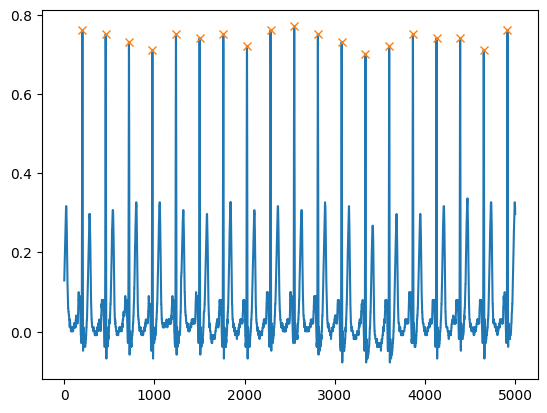

In [45]:
exampleECG = example[:, 1]
#plot
def ecg_bandpass(ecg_signal):
    return bandpass_filter(ecg_signal, lowcut=0.5, highcut=40.0, order=4, fs=250)

plt.plot(exampleECG)

# Find R-peaks and plot
test = lambda signal_id: nk.ecg_rate(nk.ecg_findpeaks(ecg_bandpass(exampleECG), sampling_rate=fs)['ECG_R_Peaks'], sampling_rate=fs)
t = test('sfdfs')
print(t)
# plot r peaks
r_peaks = nk.ecg_findpeaks(ecg_bandpass(exampleECG), sampling_rate=fs)['ECG_R_Peaks']
plt.plot(r_peaks, exampleECG[r_peaks], "x")